#Imports

In [1]:
%matplotlib inline

In [3]:
# FOR GPU
!pip install torch torchvision torchaudio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import librosa

import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import os
import csv
import IPython




     |████████████████████████████████| 1.9MB 28.5MB/s 


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Generating Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls /content/drive/Shareddrives/ASRproject/

carhorn_noise_tensor.pt  noise_0.wav	      train-clean-100.tar.gz
data			 noise_data.pt	      urbannoise
dataset			 noise_tensor.pt      urbannoise.gz
dog_noise_tensor.pt	 noisy_voice_0.wav    UrbanSound8K
LibriSpeech		 noisy_voice_data.pt  voice_0.wav
model			 out.txt	      voice_data.pt
models			 sample_nv.wav	      voice_tensor.pt
multi			 test.wav
new_model		 tmp.wav


In [ ]:
# from torchaudio.datasets import LIBRISPEECH
# librispeech_dataset = LIBRISPEECH("/content/drive/Shareddrives/ASRproject",download=True)

In [7]:
% cd /content/drive/Shareddrives/ASRproject/
!ls

/content/drive/Shareddrives/ASRproject
carhorn_noise_tensor.pt  noise_0.wav	      train-clean-100.tar.gz
data			 noise_data.pt	      urbannoise
dataset			 noise_tensor.pt      urbannoise.gz
dog_noise_tensor.pt	 noisy_voice_0.wav    UrbanSound8K
LibriSpeech		 noisy_voice_data.pt  voice_0.wav
model			 out.txt	      voice_data.pt
models			 sample_nv.wav	      voice_tensor.pt
multi			 test.wav
new_model		 tmp.wav


In [8]:
# generate_data.py

# # global params

# Sample rate to read audio
sample_rate = 8000
# Minimum duration of audio files to consider
min_duration = 1.5
#Frame length for training data
frame_length = 8064
# hop length for clean voice files
hop_length_frame = 8064
# hop length for noise files
hop_length_frame_noise = 5000

#nb of points for fft(for spectrogram computation)
n_fft = 255
#hop length for fft
hop_length_fft = 63


def subsample_list(l,n):
    indices = torch.randperm(len(l))[:n]
    new_l = []
    for i in indices:
        new_l.append(l[i])
    return new_l


def get_voice_files(vdir,num_samples):
    """
        returns all the voice files in librispeech
    """
    voice_files = []

    for r,d,files in os.walk(vdir):
        for f in files:
            if f.endswith(('.mp3','.flac','.wav')):
                voice_files.append(os.path.join(r,f))
    
    return subsample_list(voice_files,num_samples)

def get_noise_files(ndir,classIds,num_samples):
    """
        returns all the noise files in urbannoise8k 
        filters based on classIds
    """
    noise_files = []
    
    for r,d,files in os.walk(ndir):
        for f in files:
            if f.endswith(('.mp3','.flac','.wav')) and f.split('-')[1] in classIds:
                noise_files.append(os.path.join(r,f))
    
    return subsample_list(noise_files,num_samples)



def audios_to_tensor(audio_files,sample_rate,frame_len,hop_len,min_dur):
    """
        return torch tensor for audio files 
    """
    print("Converting Audio to Tensor")
    out = display(IPython.display.Pretty('Starting'),display_id=True)
    ret_tensor = []
    for i,f in enumerate(audio_files):
        # print(i,'/',len(audio_files),end='\r')
        out.update(IPython.display.Pretty(f'{i+1}/{len(audio_files)}'))
        
        waveform,_= librosa.load(str(f),sr=sample_rate)
        waveform = torch.tensor(waveform)
        dur = librosa.get_duration(y=waveform,sr=sample_rate)
        if dur >= min_dur:
            waveform_segments = [waveform[i:i+frame_len] for i in range(
                0,waveform.shape[0]-frame_len+1,hop_len
            )]
            waveform_segments = torch.vstack(waveform_segments)
            ret_tensor.append(waveform_segments)
            
        else :
            # print("Skip File: "+f)
            pass
    
    return torch.vstack(ret_tensor)




def create_data(voice_tensor,noise_tensor,num_samples,sample_rate,savePath=None):
    """
        generates voice,noise,noisy_voice data by randomly mixing 
        voice and noise data
    """
    flen = voice_tensor.shape[1]
    voice = torch.zeros((num_samples,flen))
    noise = torch.zeros((num_samples,flen))
    noisy_voice = torch.zeros((num_samples,flen))
    print('Creating Data')
    out = display(IPython.display.Pretty('Starting'),display_id=True)
    for i in range(num_samples):
      # print(i,'/',num_samples,end='\r')
      out.update(IPython.display.Pretty(f'{i+1}/{num_samples}'))

      id_voice = np.random.randint(0, voice_tensor.shape[0])
      id_noise = np.random.randint(0, noise_tensor.shape[0])
      level_noise = np.random.uniform(0.2,0.8)
      voice[i,:] = voice_tensor[id_voice,:]
      noise[i,:] = level_noise * noise_tensor[id_noise,:]
      noisy_voice[i:] = voice[i,:] + noise[i,:]
  
    if savePath is not None:
      torch.save(voice,os.path.join(savePath,'voice_data.pt'))
      torch.save(noise,os.path.join(savePath,'noise_data.pt'))
      torch.save(noisy_voice,os.path.join(savePath,'noisy_voice_data.pt'))
    
    return noisy_voice,voice,noise



#https://github.com/fgnt/pb_bss/blob/master/pb_bss/evaluation/module_si_sdr.py
def si_sdr(reference, estimation):
    """
    Scale-Invariant Signal-to-Distortion Ratio (SI-SDR)
    Args:
        reference: numpy.ndarray, [..., T]
        estimation: numpy.ndarray, [..., T]
    Returns:
        SI-SDR
    [1] SDR– Half- Baked or Well Done?
    http://www.merl.com/publications/docs/TR2019-013.pdf
    >>> np.random.seed(0)
    >>> reference = np.random.randn(100)
    >>> si_sdr(reference, reference)
    inf
    >>> si_sdr(reference, reference * 2)
    inf
    >>> si_sdr(reference, np.flip(reference))
    -25.127672346460717
    >>> si_sdr(reference, reference + np.flip(reference))
    0.481070445785553
    >>> si_sdr(reference, reference + 0.5)
    6.3704606032577304
    >>> si_sdr(reference, reference * 2 + 1)
    6.3704606032577304
    >>> si_sdr([1., 0], [0., 0])  # never predict only zeros
    nan
    >>> si_sdr([reference, reference], [reference * 2 + 1, reference * 1 + 0.5])
    array([6.3704606, 6.3704606])
    """
    estimation, reference = np.broadcast_arrays(estimation, reference)

    # assert reference.dtype == np.float64, reference.dtype
    # assert estimation.dtype == np.float64, estimation.dtype

    reference_energy = np.sum(reference ** 2, axis=-1, keepdims=True)

    # This is $\alpha$ after Equation (3) in [1].
    optimal_scaling = np.sum(reference * estimation, axis=-1, keepdims=True) \
        / reference_energy

    # This is $e_{\text{target}}$ in Equation (4) in [1].
    projection = optimal_scaling * reference

    # This is $e_{\text{res}}$ in Equation (4) in [1].
    noise = estimation - projection

    ratio = np.sum(projection ** 2, axis=-1) / np.sum(noise ** 2, axis=-1)
    return 10 * np.log10(ratio)




In [ ]:
# voice_dir = './LibriSpeech/train-clean-100/'
# noise_dir = './UrbanSound8K/audio/'
# num_voice = 10000
# num_noise = 1000

# # classes to consider
# classId_map = {
#     'dog_bark':'3'
# }


# voice_files = get_voice_files(voice_dir,num_voice)
# noise_files = get_noise_files(noise_dir,[classId_map['dog_bark']],num_noise)


# print('#voice files',len(voice_files))
# print('#noise files',len(noise_files))




In [ ]:
# voice_tensor = audios_to_tensor(voice_files,sample_rate,frame_length,hop_length_frame,min_duration)
# noise_tensor = audios_to_tensor(noise_files,sample_rate,frame_length,hop_length_frame_noise,min_duration)

# print('Voice Tensor Shape',voice_tensor.shape)
# print('Noise Tensor Shape',noise_tensor.shape)




In [ ]:
# # save tensors
# torch.save(voice_tensor,'voice_tensor.pt')
# torch.save(noise_tensor,'noise_tensor.pt')

In [9]:
voice_tensor = torch.load('./voice_tensor.pt')
noise_tensor = torch.load('./noise_tensor.pt')
print(voice_tensor.shape,noise_tensor.shape)

torch.Size([120974, 8064]) torch.Size([3694, 8064])


In [10]:
num_samples=5000
# output_dir = './data/'
# print('Removing old data',os.system(f'rm -r {output_dir}'))
# os.makedirs(output_dir)
# os.makedirs(os.path.join(output_dir,'voice'))
# os.makedirs(os.path.join(output_dir,'noise'))
# os.makedirs(os.path.join(output_dir,'noisy_voice'))

nv_data,v_data,n_data = create_data(voice_tensor,noise_tensor,num_samples,sample_rate,'./')


Creating Data


5000/5000

In [11]:
!ls

carhorn_noise_tensor.pt  noise_0.wav	      train-clean-100.tar.gz
data			 noise_data.pt	      urbannoise
dataset			 noise_tensor.pt      urbannoise.gz
dog_noise_tensor.pt	 noisy_voice_0.wav    UrbanSound8K
LibriSpeech		 noisy_voice_data.pt  voice_0.wav
model			 out.txt	      voice_data.pt
models			 sample_nv.wav	      voice_tensor.pt
multi			 test.wav
new_model		 tmp.wav


#Speech Dataset Class


In [12]:
# modify this class to directly take loaded files

class SpeechDataset(torch.utils.data.Dataset):
  
  def __init__(self,nvd,vd,nd,sample_rate=sample_rate,n_fft=n_fft,hop_length_fft=hop_length_fft):
    
    # store the file names
    self.size = nvd.shape[0]
    
    noisy_voice_waveforms = nvd
    self.noisy_voice_spectograms = torch.stft(noisy_voice_waveforms,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)

    voice_waveforms = vd
    self.voice_spectograms = torch.stft(voice_waveforms,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)

    noise_waveforms = nd
    self.noise_spectograms = torch.stft(noise_waveforms,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)

    

  def __len__(self):
    return self.size
    
  def __getitem__(self,i):
    return self.noisy_voice_spectograms[i],self.voice_spectograms[i],self.noise_spectograms[i]



#Prepare Training,Validation,Testing List

In [13]:
dataset_dir = '/content/drive/Shareddrives/ASRproject/data/'

file_list = [(os.path.join(dataset_dir,'noisy_voice',f'{i}.wav'),
              os.path.join(dataset_dir,'voice',f'{i}.wav'),
              os.path.join(dataset_dir,'noise',f'{i}.wav')
              ) for i in range(num_samples)]
print(file_list[-1])


('/content/drive/Shareddrives/ASRproject/data/noisy_voice/4999.wav', '/content/drive/Shareddrives/ASRproject/data/voice/4999.wav', '/content/drive/Shareddrives/ASRproject/data/noise/4999.wav')


In [14]:
# %cd  '/content/drive/Shareddrives/ASRproject/'
# # %cd urbannoise
# !file --mime-type urbannoise
IPython.display.Audio(file_list[0][0],rate=sample_rate)

In [15]:
#  create train val splits
num_train = 4000
num_val = 500
num_test = 500

train_set = SpeechDataset(nv_data[:num_train],v_data[:num_train],n_data[:num_train])
val_set =SpeechDataset(nv_data[num_train:num_train+num_val],v_data[num_train:num_train+num_val],n_data[num_train:num_train+num_val])
test_set =SpeechDataset(nv_data[num_train+num_val:],v_data[num_train+num_val:],n_data[num_train+num_val:])

print(train_set[0][0].shape)

torch.Size([128, 128, 2])


In [16]:
IPython.display.Audio(torch.istft(train_set[0][0],n_fft=255,hop_length=63,length=8064,return_complex=False),rate=sample_rate)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:655: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:787.)
  normalized, onesided, length, return_complex)


#DataLoaders

In [17]:
BATCH_SIZE = 16
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

# Network

U-NET

In [18]:
from torchsummary import summary

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True)
    )

def single_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True)
    )

class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        nfilter = 16
        self.dconv_down1 = double_conv(2, nfilter)
        self.dconv_down2 = double_conv(nfilter, 2*nfilter)
        self.dconv_down3 = double_conv(2*nfilter, 4*nfilter)
        self.dconv_down4 = double_conv(4*nfilter, 8*nfilter)
        self.dconv_down5 = double_conv(8*nfilter, 16*nfilter)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=(2,2))
        self.drop = nn.Dropout(p=0.5) #inplace parameter set to false by default, make it true?
        self.upsample = nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True)  # check extra parameters
        
        self.sconv_up4 = single_conv(16*nfilter, 8*nfilter)
        self.dconv_up4 = double_conv(16*nfilter , 8*nfilter)
        self.sconv_up3 = single_conv(8*nfilter, 4*nfilter)
        self.dconv_up3 = double_conv(8*nfilter , 4*nfilter)
        self.sconv_up2 = single_conv(4*nfilter, 2*nfilter)
        self.dconv_up2 = double_conv(4*nfilter , 2*nfilter)
        self.sconv_up1 = single_conv(2*nfilter, nfilter)
        self.dconv_up1 = double_conv(2*nfilter , nfilter)
        
        self.sconv_plast = single_conv(nfilter, 2)
        self.conv_last = nn.Conv2d(2,2,kernel_size=3, padding=1)
    
    def forward(self, x):
        x = x.transpose(1,3)
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        drop4 = self.drop(x)
        x = self.maxpool(drop4)

        x = self.dconv_down5(x)
        x = self.drop(x)

        x = self.upsample(x)
        x = self.sconv_up4(x)
        x = torch.cat([x, drop4], dim=1)
        x = self.dconv_up4(x)

        x = self.upsample(x)
        x = self.sconv_up3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = self.sconv_up2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = self.sconv_up1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        
        x = self.sconv_plast(x)
        x = self.conv_last(x)
        # commenting the tanh layer
        # x = torch.tanh(x)
    
        return x.transpose(1,3)



In [19]:
input = torch.rand(16, 128, 128 , 2).to(device)
unet = Unet().to(device)
# summary(unet, input_size=(128, 128, 2))

print(unet(input).shape)

torch.Size([16, 128, 128, 2])


MULTI BAND DENSE NET

In [20]:
def crop_center(h1, h2):
    h1_shape = h1.size()
    h2_shape = h2.size()

    if h1_shape[3] == h2_shape[3]:
        return h1
    elif h1_shape[3] < h2_shape[3]:
        raise ValueError('h1_shape[3] must be greater than h2_shape[3]')

    # s_freq = (h2_shape[2] - h1_shape[2]) // 2
    # e_freq = s_freq + h1_shape[2]
    s_time = (h1_shape[3] - h2_shape[3]) // 2
    e_time = s_time + h2_shape[3]
    h1 = h1[:, :, :, s_time:e_time]

    return h1

In [ ]:
class Conv2DBNActiv(nn.Module):

    def __init__(self, nin, nout, ksize=3, stride=1, pad=1, dilation=1, activ=nn.ReLU):
        super(Conv2DBNActiv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                nin, nout,
                kernel_size=ksize,
                stride=stride,
                padding=pad,
                dilation=dilation,
                bias=False),
            nn.BatchNorm2d(nout),
            activ()
        )

    def __call__(self, x):
        return self.conv(x)


class SeperableConv2DBNActiv(nn.Module):

    def __init__(self, nin, nout, ksize=3, stride=1, pad=1, dilation=1, activ=nn.ReLU):
        super(SeperableConv2DBNActiv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                nin, nin,
                kernel_size=ksize,
                stride=stride,
                padding=pad,
                dilation=dilation,
                groups=nin,
                bias=False),
            nn.Conv2d(
                nin, nout,
                kernel_size=1,
                bias=False),
            nn.BatchNorm2d(nout),
            activ()
        )

    def __call__(self, x):
        return self.conv(x)


class Encoder(nn.Module):

    def __init__(self, nin, nout, ksize=3, stride=1, pad=1, activ=nn.LeakyReLU):
        super(Encoder, self).__init__()
        self.conv1 = Conv2DBNActiv(nin, nout, ksize, 1, pad, activ=activ)
        self.conv2 = Conv2DBNActiv(nout, nout, ksize, stride, pad, activ=activ)

    def __call__(self, x):
        skip = self.conv1(x)
        h = self.conv2(skip)

        return h, skip


class Decoder(nn.Module):

    def __init__(self, nin, nout, ksize=3, stride=1, pad=1, activ=nn.ReLU, dropout=False):
        super(Decoder, self).__init__()
        self.conv = Conv2DBNActiv(nin, nout, ksize, 1, pad, activ=activ)
        self.dropout = nn.Dropout2d(0.1) if dropout else None

    def __call__(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        if skip is not None:
            print(1, skip.shape, x.shape)
            skip = crop_center(skip, x)
            print(2, skip.shape, x.shape)
            x = torch.cat([x, skip], dim=1)
            print(3, skip.shape, x.shape)
        h = self.conv(x)

        if self.dropout is not None:
            h = self.dropout(h)

        return h


class ASPPModule(nn.Module):

    def __init__(self, nin, nout, dilations=(4, 8, 16), activ=nn.ReLU):
        super(ASPPModule, self).__init__()
        self.conv1 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, None)),
            Conv2DBNActiv(nin, nin, 1, 1, 0, activ=activ)
        )
        self.conv2 = Conv2DBNActiv(nin, nin, 1, 1, 0, activ=activ)
        self.conv3 = SeperableConv2DBNActiv(
            nin, nin, 3, 1, dilations[0], dilations[0], activ=activ)
        self.conv4 = SeperableConv2DBNActiv(
            nin, nin, 3, 1, dilations[1], dilations[1], activ=activ)
        self.conv5 = SeperableConv2DBNActiv(
            nin, nin, 3, 1, dilations[2], dilations[2], activ=activ)
        self.bottleneck = nn.Sequential(
            Conv2DBNActiv(nin * 5, nout, 1, 1, 0, activ=activ),
            nn.Dropout2d(0.1)
        )

    def forward(self, x):
        _, _, h, w = x.size()
        feat1 = F.interpolate(self.conv1(x), size=(h, w), mode='bilinear', align_corners=True)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)
        feat5 = self.conv5(x)
        out = torch.cat((feat1, feat2, feat3, feat4, feat5), dim=1)
        bottle = self.bottleneck(out)
        return bottle


In [ ]:
class BaseASPPNet(nn.Module):

    def __init__(self, nin, ch, dilations=(4, 8, 16)):
        super(BaseASPPNet, self).__init__()
        self.enc1 = Encoder(nin, ch, 3, 2, 1)
        self.enc2 = Encoder(ch, ch * 2, 3, 2, 1)
        self.enc3 = Encoder(ch * 2, ch * 4, 3, 2, 1)
        self.enc4 = Encoder(ch * 4, ch * 8, 3, 2, 1)

        self.aspp = ASPPModule(ch * 8, ch * 16, dilations)

        self.dec4 = Decoder(ch * (8 + 16), ch * 8, 3, 1, 1)
        self.dec3 = Decoder(ch * (4 + 8), ch * 4, 3, 1, 1)
        self.dec2 = Decoder(ch * (2 + 4), ch * 2, 3, 1, 1)
        self.dec1 = Decoder(ch * (1 + 2), ch, 3, 1, 1)

    def __call__(self, x):
        h, e1 = self.enc1(x)
        print(x.shape, e1.shape)
        h, e2 = self.enc2(h)
        h, e3 = self.enc3(h)
        h, e4 = self.enc4(h)

        h = self.aspp(h)

        h = self.dec4(h, e4)
        h = self.dec3(h, e3)
        h = self.dec2(h, e2)
        h = self.dec1(h, e1)

        return h


class CascadedASPPNet(nn.Module):

    def __init__(self, n_fft):
        super(CascadedASPPNet, self).__init__()
        self.stg1_low_band_net = BaseASPPNet(2, 16)
        self.stg1_high_band_net = BaseASPPNet(2, 16)

        self.stg2_bridge = Conv2DBNActiv(18, 8, 1, 1, 0)
        self.stg2_full_band_net = BaseASPPNet(8, 16)

        self.stg3_bridge = Conv2DBNActiv(34, 16, 1, 1, 0)
        self.stg3_full_band_net = BaseASPPNet(16, 32)

        self.out = nn.Conv2d(32, 2, 1, bias=False)
        self.aux1_out = nn.Conv2d(16, 2, 1, bias=False)
        self.aux2_out = nn.Conv2d(16, 2, 1, bias=False)

        self.max_bin = n_fft // 2
        self.output_bin = n_fft // 2 + 1

        self.offset = 128

    def forward(self, x):
        mix = x.detach()
        x = x.clone()

        x = x[:, :, :self.max_bin]

        print("stage1",x.shape)
        bandw = x.size()[2] // 2
        aux1 = torch.cat([
            self.stg1_low_band_net(x[:, :, :bandw]),
            self.stg1_high_band_net(x[:, :, bandw:])
        ], dim=2)
        print("stage1: aux",aux1.shape)
        h = torch.cat([x, aux1], dim=1)
        aux2 = self.stg2_full_band_net(self.stg2_bridge(h))

        h = torch.cat([x, aux1, aux2], dim=1)
        h = self.stg3_full_band_net(self.stg3_bridge(h))

        mask = torch.sigmoid(self.out(h))
        mask = F.pad(
            input=mask,
            pad=(0, 0, 0, self.output_bin - mask.size()[2]),
            mode='replicate')

        if self.training:
            aux1 = torch.sigmoid(self.aux1_out(aux1))
            aux1 = F.pad(
                input=aux1,
                pad=(0, 0, 0, self.output_bin - aux1.size()[2]),
                mode='replicate')
            aux2 = torch.sigmoid(self.aux2_out(aux2))
            aux2 = F.pad(
                input=aux2,
                pad=(0, 0, 0, self.output_bin - aux2.size()[2]),
                mode='replicate')
            return mask * mix, aux1 * mix, aux2 * mix
        else:
            return mask * mix

    def predict(self, x_mag):
        h = self.forward(x_mag)

        if self.offset > 0:
            h = h[:, :, :, self.offset:-self.offset]
            assert h.size()[3] > 0

        return h

In [ ]:
input = torch.rand(16, 2, 512 , 512).to(device)
casaspnet = CascadedASPPNet(1023).to(device)
print(casaspnet(input).shape)


stage1 torch.Size([16, 2, 511, 512])


RuntimeError: ignored

# TRAINING

In [21]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.001

## Create an instance of our network
net = Unet()

## Move it to the GPU
net = net.to(device)

# L1 loss
criterion = torch.nn.SmoothL1Loss()

# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [22]:
from tqdm import tqdm_notebook

## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 20

epoch_loss, epoch_val_loss = [], []


for e in range(N_EPOCHS):
  
    print("EPOCH:",e)

    ### TRAINING LOOP
    running_loss = 0

    ## Put the network in training mode
    net.train()

    for i, batch in enumerate(tqdm_notebook(train_dl)):

        # Get a batch from the dataloader
        x = batch[0]
        noises = batch[2]

        # move the batch to GPU
        x = x.to(device)
        noises = noises.to(device)
        
        # Compute the network output
        y = net(x)

        # Compute the loss
        loss = criterion(y, noises)

        # Reset the gradients
        optimizer.zero_grad()

        # Compute the gradients
        loss.backward()

        # Apply one step of the descent algorithm to update the weights
        optimizer.step()

        ## Compute some statistics
        with torch.no_grad():
            running_loss += loss.item()

    print("Training loss:", running_loss/float(len(train_set)))

    epoch_loss.append(running_loss/len(train_set))
    
    ### Validation LOOP
    running_val_loss = 0
  
    ## Put the network in validation mode
    net.eval()

    for i, batch in enumerate(val_dl):
      with torch.no_grad():

        # Get a batch from the dataloader
        x = batch[0]
        noises = batch[2]

        # move the batch to GPU
        x = x.to(device)
        noises = noises.to(device)
        
        # Compute the network output
        y = net(x)

        # Compute the loss
        loss = criterion(y, noises)

        ## Compute some statistics
        running_val_loss += loss.item()

    print("Validation loss:", running_val_loss/float(len(val_set)))

    epoch_val_loss.append(running_val_loss/len(val_set))
    


EPOCH: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training loss: 0.003261625253595412
Validation loss: 0.003219231478869915
EPOCH: 1



Training loss: 0.002981277071638033
Validation loss: 0.0030572851821780204
EPOCH: 2



Training loss: 0.002677824999205768
Validation loss: 0.0025278902575373648
EPOCH: 3



Training loss: 0.0024142349483445287
Validation loss: 0.0023925266340374947
EPOCH: 4



Training loss: 0.00216560472571291
Validation loss: 0.0023034831658005715
EPOCH: 5



Training loss: 0.0019892417630180716
Validation loss: 0.0018884588442742824
EPOCH: 6



Training loss: 0.0017202317439951004
Validation loss: 0.0018898379318416118
EPOCH: 7



Training loss: 0.001572375836665742
Validation loss: 0.001569435929879546
EPOCH: 8



Training loss: 0.0015058860152494162
Validation loss: 0.0014656572919338941
EPOCH: 9



Training loss: 0.0013820958082797006
Validation loss: 0.0013912218119949103
EPOCH: 10



Training loss: 0.0013839282570406795
Validation loss: 0.0013200184386223555
EPOCH: 11



Training loss: 0.0012529045700794086
Validation loss: 0.0013711651414632798
EPOCH: 12



Training loss: 0.001207875220105052
Validation loss: 0.001277232736349106
EPOCH: 13



Training loss: 0.0011900282299611717
Validation loss: 0.0011917704697698354
EPOCH: 14



Training loss: 0.0011226223804987967
Validation loss: 0.0012812992250546813
EPOCH: 15



Training loss: 0.0010719488384202122
Validation loss: 0.0011953754890710116
EPOCH: 16



Training loss: 0.001082854659180157
Validation loss: 0.001166339415125549
EPOCH: 17



Training loss: 0.0010816263948800042
Validation loss: 0.0011426247600466012
EPOCH: 18



Training loss: 0.0010575317012844606
Validation loss: 0.0011065260665491224
EPOCH: 19



Training loss: 0.0010355338335502893
Validation loss: 0.0012010118858888745


#Plots

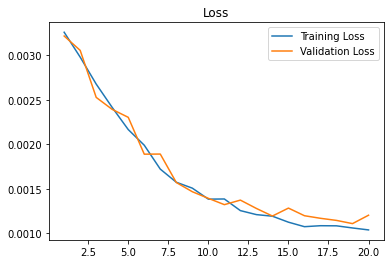

In [23]:
epochs = range(1,len(epoch_loss)+1)
plt.plot(epochs,epoch_loss,label='Training Loss')
plt.plot(epochs,epoch_val_loss,label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

#Testing

In [ ]:


# for now test on val set
net.eval()
test_loss = 0
test_sdr = 0

for i,batch in enumerate(test_dl):
  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    noises = batch[2]

    # move the batch to GPU
    x = x.to(device)
    noises = noises.to(device)
    
    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, noises)
    test_loss += loss.item()
    dim = n_fft//2 + 1
    reference = noises.to('cpu').detach().numpy()
    reference = np.sqrt(reference[:,:,:,0]**2 + reference[:,:,:,1]**2)
    reference = reference.reshape((x.shape[0],dim*dim))

    estimation = y.to('cpu').detach().numpy()
    estimation = np.sqrt(estimation[:,:,:,0]**2 + estimation[:,:,:,1]**2)
    estimation = estimation.reshape((x.shape[0],dim*dim))

    sdr = si_sdr(reference,estimation)
    test_sdr += np.sum(sdr)

test_loss = test_loss/len(test_set)
test_sdr = test_sdr/len(test_set)

print('Test Loss',test_loss)
print('Test SDR',test_sdr)


Test Loss 0.0011434288546442986
Test SDR 1.36243759059906


In [24]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     / 2.1MB 3.1MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     \ 307kB 51.7MB/s
     | 71kB 52.7MB/s
     | 65.4MB 46kB/s
     |████████████████████████████████| 163kB 36.2MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=e8f80e0ef9d9f4554060d5f0b2ddea78fa029a3ba176dd8a3d93a931925175ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-48s97743/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=c41f639ced57a839e517ef68844a9ea5938d46a0f83a06a0e6c5637097eceaf3
  Stored in directory: /root/.cache/pip/wheels/6b/6c/b2/d49af4b7ee4ce275cf2511484b043e09b9cb7ae90c1accb17a
  Created wheel for pesq: filename=pesq-0.0.2-cp37-cp37m-linux_x86_64.whl size=210738 sha256=77aa7d52f8aad0e8a29a3bbb349dadd229010e64ea0b23ec2f7ecf0128b7add3
  Stored in di

In [37]:
import pysepm
net.eval()
test_loss = 0
test_sdr = 0

for i,batch in enumerate(test_dl):
  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    noises = batch[2]

    # move the batch to GPU
    x = x.to(device)
    noises = noises.to(device)
    
    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, noises)
    test_loss += loss.item()
    n1=len(x)
    # y1 = y.to('cpu').detach().numpy()
    # x1 = x.to('cpu').detach().numpy()
    for j in range(n1):
      # n_fft=255,hop_length=63,length=8064,return_complex=False
      a1=torch.istft(y[j],n_fft=n_fft,hop_length=hop_length_fft,length=8064,return_complex=False)
      a2=torch.istft(x[j],n_fft=n_fft,hop_length=hop_length_fft,length=8064,return_complex=False)
      # print(a2.shape,a1.shape)
      a3=a1.to('cpu').detach().numpy()
      a4=a2.to('cpu').detach().numpy()
      test_sdr+=pysepm.fwSNRseg(a4,a3,sample_rate)
    # torch.istft(input, n_fft, hop_length=None, win_length=None, window=None, center=True, normalized=False, onesided=None, length=None, return_complex=False)
    # dim = n_fft//2 + 1
    # reference = noises.to('cpu').detach().numpy()
    # reference = np.sqrt(reference[:,:,:,0]**2 + reference[:,:,:,1]**2)
    # reference = reference.reshape((x.shape[0],dim*dim))

    
    # estimation = np.sqrt(estimation[:,:,:,0]**2 + estimation[:,:,:,1]**2)
    # estimation = estimation.reshape((x.shape[0],dim*dim))

    # sdr = si_sdr(reference,estimation)
    # test_sdr += np.sum(sdr)

test_loss = test_loss/len(test_set)
test_sdr = test_sdr/len(test_set)

print('Test Loss',test_loss)
print('Test SDR',test_sdr)

Test Loss 0.001029152509290725
Test SDR 6.787722219555663


#Inference

Converting Audio to Tensor


1/1

torch.Size([1, 128, 128, 2]) torch.Size([1, 128, 128, 2])
Noisy Voice


Predicted Voice


Predicted Noise


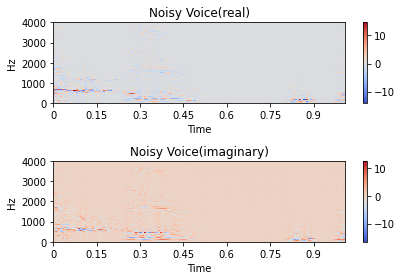

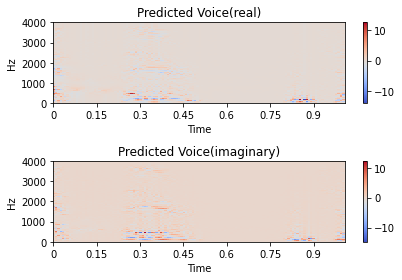

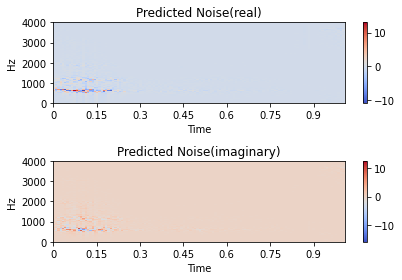

In [ ]:
import librosa.display
import pysepm

test_file = '/content/drive/Shareddrives/ASRproject/data/noisy_voice/4070.wav'

def plot_spec(spec,title):
  plt.figure()
  plt.subplot(2, 1, 1)
  plt.title(f'{title}(real)')
  librosa.display.specshow(spec[:,:,0], x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
  plt.colorbar()

  plt.subplot(2, 1, 2)
  plt.title(f'{title}(imaginary)')
  librosa.display.specshow(spec[:,:,1], x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
  plt.colorbar()

  plt.tight_layout()


def infer_true_voice(noisy_voice_file):
  wavs = audios_to_tensor([noisy_voice_file],sample_rate,frame_length,hop_length_frame,0)
  specs = torch.stft(wavs,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)
  
  net.eval()
  x = specs
  x = x.to(device)
  y = net(x)
  print(x.shape,y.shape)
  noise = y.to('cpu')
  noisy_voice = x.to('cpu')
  voice = noisy_voice - noise

  plot_spec(noisy_voice[0].detach().numpy(),'Noisy Voice')
  plot_spec(voice[0].detach().numpy(),'Predicted Voice')
  plot_spec(noise[0].detach().numpy(),'Predicted Noise')

  noisy_voice_wav = torch.istft(noisy_voice,n_fft=n_fft,hop_length=hop_length_fft,length=frame_length,return_complex=False)
  voice_wav = torch.istft(voice,n_fft=n_fft,hop_length=hop_length_fft,length=frame_length,return_complex=False)
  noise_wav = torch.istft(noise,n_fft=n_fft,hop_length=hop_length_fft,length=frame_length,return_complex=False)

  # print(torch.sum(noise))
  return noisy_voice_wav.detach().numpy(),voice_wav.detach().numpy(),noise_wav.detach().numpy()

nv_wav,v_wav,n_wav = infer_true_voice(test_file)

print('Noisy Voice')
display(IPython.display.Audio(nv_wav,rate=sample_rate))
print('Predicted Voice')
display(IPython.display.Audio(v_wav,rate=sample_rate))
print('Predicted Noise')
display(IPython.display.Audio(n_wav,rate=sample_rate))

In [ ]:
# torch.save(net.state_dict(),'./new_model')